In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.models import resnet50, ResNet50_Weights
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torchinfo import summary
import timeit
import os
from prettytable import PrettyTable, SINGLE_BORDER
from torch.quantization import prepare, convert, fuse_modules, get_default_qconfig
from PIL import Image
import copy

This notebook will demonstrate model compression techniques and export an iOS compatible coreML model to load into mobile devices

In [2]:
if torch.cuda.is_available():
    device_name = 'cuda'
elif torch.backends.mps.is_available():
    device_name = 'mps'
else:
    device_name = 'cpu'

device = torch.device(device_name)
print(device)

cuda


Code from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [3]:
batch_size=128

In [4]:
train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
    ])
    
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

In [5]:
# Dataloader

# Define the directory for the dataset
data_dir = "data"

# Create the directory if it doesn't exist
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=train_transform
)

testing_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=val_transform
)


train_data_loader  = DataLoader(training_data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2)

test_data_loader  = DataLoader(testing_data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Define the directory for the dataset
model_dir = "model"

# Create the directory if it doesn't exist
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    mode = 'train'
else:
    if len(os.listdir(model_dir)) == 0:
        mode = 'train'
        print("no model checkpoints exist")
    else:
        mode = 'eval'
        print("model checkpoints already exist")

# # Mode Override
# mode = 'train'
print("mode", mode)

mode train


In [7]:
epochs = 5

## Teacher Model

Resnet50 (Modified for CIFAR10)

In [8]:
class ResNet50SmallPretrained(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet50SmallPretrained, self).__init__()
        # Load pretrained ResNet50
        resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
        
        # Method 1: Modify first convolution layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        
        # Copy weights from pretrained model with adaptation
        with torch.no_grad():
            # Adapt the weights by averaging over the original kernel size
            original_weights = resnet.conv1.weight
            new_weights = torch.mean(original_weights.view(64, 3, 7*7), dim=2).view(64, 3, 1, 1)
            self.conv1.weight = nn.Parameter(new_weights)
        
        # Remove the original first maxpool layer as it's too aggressive for small images
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        
        # Keep the rest of the architecture
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        
        # Adjust the final layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        # No maxpool
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

In [9]:
teacher_model = ResNet50SmallPretrained().to(device)

In [10]:
teacher_model_stats = summary(teacher_model, input_size=(batch_size, 3, 32, 32), device=device)
teacher_model_stats

Layer (type:depth-idx)                   Output Shape              Param #
ResNet50SmallPretrained                  [128, 10]                 --
├─Conv2d: 1-1                            [128, 64, 34, 34]         192
├─BatchNorm2d: 1-2                       [128, 64, 34, 34]         128
├─ReLU: 1-3                              [128, 64, 34, 34]         --
├─Sequential: 1-4                        [128, 256, 34, 34]        --
│    └─Bottleneck: 2-1                   [128, 256, 34, 34]        --
│    │    └─Conv2d: 3-1                  [128, 64, 34, 34]         4,096
│    │    └─BatchNorm2d: 3-2             [128, 64, 34, 34]         128
│    │    └─ReLU: 3-3                    [128, 64, 34, 34]         --
│    │    └─Conv2d: 3-4                  [128, 64, 34, 34]         36,864
│    │    └─BatchNorm2d: 3-5             [128, 64, 34, 34]         128
│    │    └─ReLU: 3-6                    [128, 64, 34, 34]         --
│    │    └─Conv2d: 3-7                  [128, 256, 34, 34]        16,384


In [11]:
# optimizer = optim.SGD(teacher_model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(teacher_model.parameters())

In [12]:
def standard_training(epochs, data_loader, model, device, optimizer='adam', criterion='ce'):
    if optimizer == 'adam':
        optimizer = optim.Adam(model.parameters())
    else:
        raise NotImplementedError("optimizer string matcher is not implemented yet other than adam")
    if criterion == 'ce':
        criterion = nn.CrossEntropyLoss()
    else:
        raise NotImplementedError("optimizer string matcher is not implemented yet other than CrossEntropy")
    
    model.to(device)
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(tqdm(data_loader), 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device) # send to accelerator

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

        # Calculate average loss for the epoch
        avg_loss = running_loss / len(train_data_loader)
        # Print average loss for the epoch
        print(f'Epoch [{epoch + 1}/{epochs}], Average Loss: {avg_loss:.4f}')
    print('Finished Training')
    return model

In [13]:
if mode == 'train':
    teacher_model = standard_training(epochs, train_data_loader, teacher_model, device)
    torch.save(teacher_model, "model/teacher_model.pt")
else:
    torch.load("model/teacher_model.pt", map_location=device)

  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [1/5], Average Loss: 0.5243


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [2/5], Average Loss: 0.2787


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [3/5], Average Loss: 0.2262


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [4/5], Average Loss: 0.1940


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [5/5], Average Loss: 0.1701
Finished Training


## Student Model

In [14]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
            
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu1 = nn.ReLU(inplace=False)  # Changed to non-inplace
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.relu2 = nn.ReLU(inplace=False)  # Changed to non-inplace
        self.downsample = downsample
        self.stride = stride
        # # Remove FloatFunctional and use mul/add ops directly
        # self.mul_scalar = torch.ao.quantization.observer.MinMaxObserver()
        # Add this for quantized addition
        self.add = torch.ao.nn.quantized.FloatFunctional()

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        # Simple addition, will be automatically quantized
        out = self.add.add(out, identity)
        out = self.relu2(out)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.relu1 = nn.ReLU(inplace=False)  # Changed to non-inplace
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.relu2 = nn.ReLU(inplace=False)  # Changed to non-inplace
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu3 = nn.ReLU(inplace=False)  # Changed to non-inplace
        self.downsample = downsample
        self.stride = stride
        # # Remove FloatFunctional and use mul/add ops directly
        # self.mul_scalar = torch.ao.quantization.observer.MinMaxObserver()
        # Add this for quantized addition
        self.add = torch.ao.nn.quantized.FloatFunctional()

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        # Simple addition, will be automatically quantized
        out = self.add.add(out, identity)
        out = self.relu3(out)

        return out

class ResNet50SmallerStudent(nn.Module):
    def __init__(self, block, layers, num_classes=10, zero_init_residual=False,  # Changed num_classes to 10
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet50SmallerStudent, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                           "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        
        # Quantization stubs
        self.quant = torch.ao.quantization.QuantStub()
        self.dequant = torch.ao.quantization.DeQuantStub()
        
        # Modified initial conv layer for CIFAR-10
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=3, stride=1, padding=1,
                              bias=False)  # Changed kernel_size from 7 to 3, stride from 2 to 1
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=False)
        # Removed maxpool layer
        
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                     dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                     dilate=replace_stride_with_dilation[1])
        
        # Truncate Model to create a smaller model for knowledge distillation
        # self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
        #                              dilate=replace_stride_with_dilation[2])
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * block.expansion, num_classes)  # Now outputs 10 classes

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)
    
    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                          self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                              base_width=self.base_width, dilation=self.dilation,
                              norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.quant(x)
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # Removed maxpool

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        # x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        x = self.dequant(x)
        return x

    def fuse_model(self):
        """
        Fuse Conv+BN+ReLU layers throughout the model where appropriate.
        For BasicBlock and Bottleneck, the final ReLU should not be fused
        since it comes after the residual addition.
        """
        for m in self.modules():
            if type(m) == BasicBlock:
                fuse_modules(m, ['conv1', 'bn1', 'relu1'], inplace=True)
                fuse_modules(m, ['conv2', 'bn2'], inplace=True)
                if m.downsample is not None:
                    fuse_modules(m.downsample, ['0', '1'], inplace=True)
            elif type(m) == Bottleneck:
                fuse_modules(m, ['conv1', 'bn1', 'relu1'], inplace=True)
                fuse_modules(m, ['conv2', 'bn2', 'relu2'], inplace=True)
                fuse_modules(m, ['conv3', 'bn3'], inplace=True)
                if m.downsample is not None:
                    fuse_modules(m.downsample, ['0', '1'], inplace=True)

In [15]:
# Load Student Models
# Model is based off of Resnet50 Architecture 
# One instance without Knowledge Distillation
# One instance for Knowledge Distillation
# For comparison of effectiveness of KD
student_model_noKD = ResNet50SmallerStudent(Bottleneck, [3, 4, 6], num_classes=10).to(device)
student_model_KD = ResNet50SmallerStudent(Bottleneck, [3, 4, 6], num_classes=10).to(device)

In [16]:
student_model_stats = summary(student_model_noKD, input_size=(batch_size, 3, 32, 32), device=device)
student_model_stats

Layer (type:depth-idx)                   Output Shape              Param #
ResNet50SmallerStudent                   [128, 10]                 --
├─QuantStub: 1-1                         [128, 3, 32, 32]          --
├─Conv2d: 1-2                            [128, 64, 32, 32]         1,728
├─BatchNorm2d: 1-3                       [128, 64, 32, 32]         128
├─ReLU: 1-4                              [128, 64, 32, 32]         --
├─Sequential: 1-5                        [128, 256, 32, 32]        --
│    └─Bottleneck: 2-1                   [128, 256, 32, 32]        --
│    │    └─Conv2d: 3-1                  [128, 64, 32, 32]         4,096
│    │    └─BatchNorm2d: 3-2             [128, 64, 32, 32]         128
│    │    └─ReLU: 3-3                    [128, 64, 32, 32]         --
│    │    └─Conv2d: 3-4                  [128, 64, 32, 32]         36,864
│    │    └─BatchNorm2d: 3-5             [128, 64, 32, 32]         128
│    │    └─ReLU: 3-6                    [128, 64, 32, 32]         --
│ 

Regular Student Training (on Dataset)

In [17]:
if mode == 'train':
    student_model_noKD = standard_training(epochs, train_data_loader, student_model_noKD, device)
    torch.save(student_model_noKD, "model/student_model_noKD.pt")
else:
    student_model_noKD = torch.load("model/student_model_noKD.pt", map_location=device)

  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [1/5], Average Loss: 1.4192


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [2/5], Average Loss: 0.9089


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [3/5], Average Loss: 0.7170


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [4/5], Average Loss: 0.5859


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [5/5], Average Loss: 0.5180
Finished Training


Student Training from Teacher

Some code taken from: https://pytorch.org/tutorials/beginner/knowledge_distillation_tutorial.html

In [18]:
def kd_training(epochs, data_loader, teacher_model, student_model, device, soft_target_loss_weight = 0.25, ce_loss_weight = 0.75, temperature = 2, optimizer='adam', criterion='ce'):
    # Apply ``train_knowledge_distillation`` with a temperature of 2. Arbitrarily set the weights to 0.75 for CE and 0.25 for distillation loss.

    if optimizer == 'adam':
        optimizer = optim.Adam(student_model.parameters())
    else:
        raise NotImplementedError("optimizer string matcher is not implemented yet other than adam")
    if criterion == 'ce':
        criterion = nn.CrossEntropyLoss()
    else:
        raise NotImplementedError("optimizer string matcher is not implemented yet other than CrossEntropy")
    
    student_model.to(device)
    teacher_model.to(device)

    # Set teacher model to evaluation mode to not mess with gradients of teacher model
    teacher = teacher_model.eval()

    student_model.train() # Student to train mode

    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(tqdm(data_loader), 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device) # send to cuda

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            student_logits = student_model(inputs)

            with torch.no_grad():
                    teacher_logits = teacher_model(inputs)
            
            #Soften the student logits by applying softmax first and log() second
            soft_targets = nn.functional.softmax(teacher_logits / temperature, dim=-1)
            soft_prob = nn.functional.log_softmax(student_logits / temperature, dim=-1)

            # Calculate the soft targets loss. Scaled by temperature**2 as suggested by the authors of the paper "Distilling the knowledge in a neural network"
            soft_targets_loss = torch.sum(soft_targets * (soft_targets.log() - soft_prob)) / soft_prob.size()[0] * (temperature**2)

            # Calculate the true label loss
            label_loss = criterion(student_logits, labels)

            # Weighted sum of the two losses
            loss = (soft_target_loss_weight * soft_targets_loss) + (ce_loss_weight * label_loss)

            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
        
        # Calculate average loss for the epoch
        avg_loss = running_loss / len(train_data_loader)
        # Print average loss for the epoch
        print(f'Epoch [{epoch + 1}/{epochs}], Average Loss: {avg_loss:.4f}')
    print('Finished Training')
    return student_model

In [19]:
if mode == 'train':
    student_model_KD = kd_training(epochs, train_data_loader, teacher_model, student_model_KD, device)
    torch.save(student_model_KD, "model/student_model_KD.pt")
else:
    student_model_KD = torch.load("model/student_model_KD.pt", map_location=device)

  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [1/5], Average Loss: 2.0518


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [2/5], Average Loss: 1.2652


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [3/5], Average Loss: 0.9371


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [4/5], Average Loss: 0.7591


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [5/5], Average Loss: 0.6511
Finished Training


## Metrics

In [20]:
def evaluate_model(model, model_name, data_loader, device, testing_mode=False):
    correct = 0
    total = 0
    model.to(device)
    model.eval()
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in tqdm(data_loader):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    if not testing_mode:
        return correct / total
        # print(f'Accuracy of {model_name} on the 10000 test images: {100 * correct / total:.3f} %')

Accuracy Testing

In [21]:
teacher_acc = evaluate_model(teacher_model, "teacher model", test_data_loader, device)
student_noKD_acc = evaluate_model(student_model_noKD, "student model with no Knowledge Distillation", test_data_loader, device)
student_KD_acc = evaluate_model(student_model_KD, "student model with Knowledge Distillation", test_data_loader, device)

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

In [22]:
teacher_acc_percent = teacher_acc * 100
student_noKD_acc_percent = student_noKD_acc * 100
student_KD_acc_percent = student_KD_acc * 100

teacher_to_student_noKD_acc = ((teacher_acc - student_noKD_acc) / teacher_acc) * 100
teacher_to_student_KD_acc = ((teacher_acc - student_KD_acc) / teacher_acc) * 100

# Create a PrettyTable object
acc_table = PrettyTable()
acc_table.set_style(SINGLE_BORDER)

# Define the columns
acc_table.field_names = ["Model", "Accuracy", "% Decrease from Teacher"]
acc_table.add_row(["Teacher Model", f"{teacher_acc_percent:.2f} %", "-"])
acc_table.add_row(["Student Model (No KD)", f"{student_noKD_acc_percent:.2f} %", f"{teacher_to_student_noKD_acc:.2f}%"])
acc_table.add_row(["Student Model (KD)", f"{student_KD_acc_percent:.2f} %", f"{teacher_to_student_KD_acc:.2f}%"])

# Print the table
print(acc_table)

┌───────────────────────┬──────────┬─────────────────────────┐
│         Model         │ Accuracy │ % Decrease from Teacher │
├───────────────────────┼──────────┼─────────────────────────┤
│     Teacher Model     │ 92.22 %  │            -            │
│ Student Model (No KD) │ 82.00 %  │          11.08%         │
│   Student Model (KD)  │ 75.23 %  │          18.42%         │
└───────────────────────┴──────────┴─────────────────────────┘


Evaluation Speed Testing

In [23]:
num_runs = 5

In [24]:
time_teacher = timeit.timeit(lambda: evaluate_model(teacher_model, "teacher model", test_data_loader, device, testing_mode=True), number=num_runs)
time_student_noKD = timeit.timeit(lambda: evaluate_model(student_model_noKD, "student model with no Knowledge Distillation", test_data_loader, device, testing_mode=True), number=num_runs)
time_student_KD = timeit.timeit(lambda: evaluate_model(student_model_KD, "student model with Knowledge Distillation", test_data_loader, device, testing_mode=True), number=num_runs)

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

In [25]:
teacher_to_student_noKD_time = ((time_teacher - time_student_noKD) / time_teacher) * 100
teacher_to_student_KD_time = ((time_teacher - time_student_KD) / time_teacher) * 100

# Create a PrettyTable object
speed_table = PrettyTable()
speed_table.set_style(SINGLE_BORDER)

# Define the columns
speed_table.field_names = ["Model", "Device Used to Inference",f"Time Averaged over {num_runs} runs (seconds)", "% Decrease from Teacher"]
speed_table.add_row(["Teacher Model", f"{device}", f"{time_teacher:.2f}", "-"])
speed_table.add_row(["Student Model (No KD)", f"{device}", f"{time_student_noKD:.2f}", f"{teacher_to_student_noKD_time:.2f}%"])
speed_table.add_row(["Student Model (KD)", f"{device}", f"{time_student_KD:.2f}", f"{teacher_to_student_KD_time:.2f}%"])

# Print the table
print(speed_table)

┌───────────────────────┬──────────────────────────┬─────────────────────────────────────┬─────────────────────────┐
│         Model         │ Device Used to Inference │ Time Averaged over 5 runs (seconds) │ % Decrease from Teacher │
├───────────────────────┼──────────────────────────┼─────────────────────────────────────┼─────────────────────────┤
│     Teacher Model     │           cuda           │                20.32                │            -            │
│ Student Model (No KD) │           cuda           │                13.71                │          32.52%         │
│   Student Model (KD)  │           cuda           │                13.69                │          32.60%         │
└───────────────────────┴──────────────────────────┴─────────────────────────────────────┴─────────────────────────┘


Model Size Comparison

In [26]:
teacher_model_size = os.path.getsize("model/teacher_model.pt") / 1e6
student_model_size = os.path.getsize("model/student_model_KD.pt") / 1e6
teacher_to_student_model_size = (teacher_model_size - student_model_size) * 100 / teacher_model_size

# Create a PrettyTable object
size_table = PrettyTable()
size_table.set_style(SINGLE_BORDER)

# Define the columns
size_table.field_names = ["Model", f"Model Size (MB)", "% Decrease from Teacher"]
size_table.add_row(["Teacher Model", f"{teacher_model_size:.2f}", "-"])
size_table.add_row(["Student Model", f"{student_model_size:.2f}", f"{teacher_to_student_model_size:.2f}%"])

# Print the table
print(size_table)

┌───────────────┬─────────────────┬─────────────────────────┐
│     Model     │ Model Size (MB) │ % Decrease from Teacher │
├───────────────┼─────────────────┼─────────────────────────┤
│ Teacher Model │      94.42      │            -            │
│ Student Model │      34.43      │          63.54%         │
└───────────────┴─────────────────┴─────────────────────────┘


The knowledge distilled smaller model is faster than all the models and more accurate than the non knowledge distilled smaller model that was trained regularly using the training dataset

## Quantizing and Exporting KD Model into Mobile Friendly package

Following Pytorch docs for setup from: https://pytorch.org/executorch/stable/getting-started-setup.html

## Quantization

Quantization Docs: https://pytorch.org/docs/stable/quantization.html#introduction-to-quantization

We use Post Training Static Quantization (PTSQ) from pytorch. There more information of different types of quantization are provided in the quantization docs above.

In [27]:
# We take a copy of the Student model with knowledge distillation and move it to a new variable containing the copy of the model to run quantization on
student_model_KD_quant_copy = copy.deepcopy(student_model_KD)

# Quantization isn't implemented on accelerators so move model back to cpu
student_model_KD_quant_copy.to('cpu')

torch.backends.quantized.engine = 'qnnpack'

student_model_KD_quant_copy.eval()

# attach a global qconfig, which contains information about what kind
# of observers to attach. Use 'x86' for server inference and 'qnnpack'
# for mobile inference. Other quantization configurations such as selecting
# symmetric or asymmetric quantization and MinMax or L2Norm calibration techniques
# can be specified here.
# Note: the old 'fbgemm' is still available but 'x86' is the recommended default
# for server inference.
# model_fp32.qconfig = torch.ao.quantization.get_default_qconfig('fbgemm')
student_model_KD_quant_copy.qconfig = get_default_qconfig('qnnpack')

# Fuse the activations to preceding layers, where applicable.
# This needs to be done manually depending on the model architecture.
# Common fusions include `conv + relu` and `conv + batchnorm + relu`
student_model_KD_quant_copy.fuse_model()

# Prepare the model for static quantization. This inserts observers in
# the model that will observe activation tensors during calibration.
student_model_KD_prepared = prepare(student_model_KD_quant_copy)

In [28]:
# Get a batch of images for calibration
input, _ = next(iter(train_data_loader))

# Run the calibration with real data
student_model_KD_prepared(input)

tensor([[ -0.3150,  -6.0617,  11.7452,  ...,  -2.4757,  -6.5796,  -6.8057],
        [ -2.9913,  -5.3389,   8.4006,  ...,   1.0409,  -1.5811,  -2.9149],
        [ -5.6191, -12.6936,   4.8705,  ...,  19.1144, -11.5949,  -9.0764],
        ...,
        [ -1.9792,  -1.7147,   6.1368,  ...,   1.6464,  -2.8916,  -3.6043],
        [ -8.1207, -10.8889,   4.3876,  ...,   7.9950,  -6.7257,  -8.8520],
        [ -2.0201,  -5.0380,   3.3313,  ...,   9.9101,  -5.1875,  -5.0832]],
       grad_fn=<AddmmBackward0>)

In [29]:
# Convert the observed model to a quantized model. This does several things:
# quantizes the weights, computes and stores the scale and bias value to be
# used with each activation tensor, and replaces key operators with quantized
# implementations.
student_model_KD_int8 = convert(student_model_KD_prepared)

In [30]:
# https://github.com/pytorch/pytorch/issues/69426
# Can't load regular model saving method so only save weights to load
if mode == 'train':
    torch.save(student_model_KD_int8, "model/student_model_KD_int8.pt") # save full model just to compare model size
    torch.save(student_model_KD_int8.state_dict(), "model/student_model_KD_int8_state_dict.pt") # use state_dict for actual model loading
else:
    # Load Model
    student_model_KD_int8.load_state_dict(torch.load("model/student_model_KD_int8_state_dict.pt"))

Let's see how much size we saved from our previous models

In [31]:
teacher_model_size = os.path.getsize("model/teacher_model.pt") / 1e6
student_model_size = os.path.getsize("model/student_model_KD.pt") / 1e6
student_model_pytorch_quantized_size = os.path.getsize("model/student_model_KD_int8.pt") / 1e6

teacher_to_student_model_size = (teacher_model_size - student_model_size) * 100 / teacher_model_size
teacher_to_pytorch_quantized_student_model_size = (teacher_model_size - student_model_pytorch_quantized_size) * 100 / teacher_model_size

# Create a PrettyTable object
size_table = PrettyTable()
size_table.set_style(SINGLE_BORDER)

# Define the columns
size_table.field_names = ["Model", f"Model Size (MB)", "% Decrease from Teacher"]
size_table.add_row(["Teacher Model", f"{teacher_model_size:.2f}", "-"])
size_table.add_row(["Student Model", f"{student_model_size:.2f}", f"{teacher_to_student_model_size:.2f}%"])
size_table.add_row(["Pytorch Quantized Student Model", f"{student_model_pytorch_quantized_size:.2f}", f"{teacher_to_pytorch_quantized_student_model_size:.2f}%"])


# Print the table
print(size_table)

┌─────────────────────────────────┬─────────────────┬─────────────────────────┐
│              Model              │ Model Size (MB) │ % Decrease from Teacher │
├─────────────────────────────────┼─────────────────┼─────────────────────────┤
│          Teacher Model          │      94.42      │            -            │
│          Student Model          │      34.43      │          63.54%         │
│ Pytorch Quantized Student Model │       8.64      │          90.85%         │
└─────────────────────────────────┴─────────────────┴─────────────────────────┘


We see almost a 90% reduction in model size

In [32]:
student_KD_pytorch_quant_acc = evaluate_model(student_model_KD_int8, "Pytorch quantized student model", test_data_loader, 'cpu')

  0%|          | 0/79 [00:00<?, ?it/s]

In [33]:
teacher_acc_percent = teacher_acc * 100
student_noKD_acc_percent = student_noKD_acc * 100
student_KD_acc_percent = student_KD_acc * 100
student_KD_pytorch_quant_acc_percent = student_KD_pytorch_quant_acc * 100


teacher_to_student_noKD_acc = ((teacher_acc - student_noKD_acc) / teacher_acc) * 100
teacher_to_student_KD_acc = ((teacher_acc - student_KD_acc) / teacher_acc) * 100
teacher_to_student_KD_pytorch_quant_acc = ((teacher_acc - student_KD_acc) / teacher_acc) * 100

# Create a PrettyTable object
acc_table = PrettyTable()
acc_table.set_style(SINGLE_BORDER)

# Define the columns
acc_table.field_names = ["Model", "Accuracy", "% Decrease from Teacher"]
acc_table.add_row(["Teacher Model", f"{teacher_acc_percent:.2f} %", "-"])
acc_table.add_row(["Student Model (No KD)", f"{student_noKD_acc_percent:.2f} %", f"{teacher_to_student_noKD_acc:.2f}%"])
acc_table.add_row(["Student Model (KD)", f"{student_KD_acc_percent:.2f} %", f"{teacher_to_student_KD_acc:.2f}%"])
acc_table.add_row(["Student Model Quantized Int8 (KD)", f"{student_KD_pytorch_quant_acc_percent:.2f} %", f"{teacher_to_student_KD_pytorch_quant_acc:.2f}%"])

# Print the table
print(acc_table)

┌───────────────────────────────────┬──────────┬─────────────────────────┐
│               Model               │ Accuracy │ % Decrease from Teacher │
├───────────────────────────────────┼──────────┼─────────────────────────┤
│           Teacher Model           │ 92.22 %  │            -            │
│       Student Model (No KD)       │ 82.00 %  │          11.08%         │
│         Student Model (KD)        │ 75.23 %  │          18.42%         │
│ Student Model Quantized Int8 (KD) │ 75.23 %  │          18.42%         │
└───────────────────────────────────┴──────────┴─────────────────────────┘


In [34]:
time_teacher_cpu = timeit.timeit(lambda: evaluate_model(teacher_model, "teacher model", test_data_loader, 'cpu', testing_mode=True), number=num_runs)
time_student_noKD_cpu = timeit.timeit(lambda: evaluate_model(student_model_noKD, "student model with no Knowledge Distillation", test_data_loader, 'cpu', testing_mode=True), number=num_runs)
time_student_KD_cpu = timeit.timeit(lambda: evaluate_model(student_model_KD, "student model with Knowledge Distillation", test_data_loader, 'cpu', testing_mode=True), number=num_runs)
time_student_pytorch_quantized_cpu = timeit.timeit(lambda: evaluate_model(student_model_KD_int8, "Pytorch quantized student model", test_data_loader,"cpu", testing_mode=True), number=num_runs)

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

In [35]:
teacher_to_student_noKD_time = ((time_teacher_cpu - time_student_noKD_cpu) / time_teacher_cpu) * 100
teacher_to_student_KD_time = ((time_teacher_cpu - time_student_KD_cpu) / time_teacher_cpu) * 100
teacher_to_student_pytorch_quantized_time = ((time_teacher_cpu - time_student_pytorch_quantized_cpu) / time_teacher_cpu) * 100

# Create a PrettyTable object
speed_table = PrettyTable()
speed_table.set_style(SINGLE_BORDER)

# Define the columns
speed_table.field_names = ["Model", "Device used to inference", f"Time Averaged over {num_runs} runs (seconds)", "% Decrease from Teacher"]
speed_table.add_row(["Teacher Model", "CPU", f"{time_teacher_cpu:.2f}", "-"])
speed_table.add_row(["Student Model (No KD)", "CPU", f"{time_student_noKD_cpu:.2f}", f"{teacher_to_student_noKD_time:.2f}%"])
speed_table.add_row(["Student Model (KD)", "CPU", f"{time_student_KD_cpu:.2f}", f"{teacher_to_student_KD_time:.2f}%"])
speed_table.add_row(["Student Model Quantized (KD)", "CPU", f"{time_student_pytorch_quantized_cpu:.2f}", f"{teacher_to_student_pytorch_quantized_time:.2f}%"])


# Print the table
print(speed_table)

┌──────────────────────────────┬──────────────────────────┬─────────────────────────────────────┬─────────────────────────┐
│            Model             │ Device used to inference │ Time Averaged over 5 runs (seconds) │ % Decrease from Teacher │
├──────────────────────────────┼──────────────────────────┼─────────────────────────────────────┼─────────────────────────┤
│        Teacher Model         │           CPU            │                942.96               │            -            │
│    Student Model (No KD)     │           CPU            │                651.03               │          30.96%         │
│      Student Model (KD)      │           CPU            │                668.84               │          29.07%         │
│ Student Model Quantized (KD) │           CPU            │                598.93               │          36.48%         │
└──────────────────────────────┴──────────────────────────┴─────────────────────────────────────┴─────────────────────────┘


The Quantized model is slightly slower than the Original Student model with KD but this might be due to hardware differences as the quantized model is optimized for edge and mobile devices and the original model being optimized for CPU/GPU hardware and this test was done on an x86 CPU.

## Exporting as CoreML model

So after training the above quantized model, it seems to be that CoreML tools from Apple do not support fusing layers and Batch Norm 2d Quantized from Pytorch. To quantize the model it seems that we should be using coreML's own optimize functions to quantize our model for compatibility. While the selection of quantization techinques are similar, they are done in a slightly different manner. The CoreML implementation of PTSQ does not calibrate activations from a representative sample dataset. Since coreML is the library that the apple hardware is optimized for, we will use this library instead and remake the Knowledge Distilled Model without fusing layers.

Note that the above model still should work for other mobile and edge platforms as a quantized model, but this will be hardware dependent.

This model should be the same overall architecture of KD student model with quantization, without fused layers.

We are still using PTSQ (documentation for coreML [here](https://apple.github.io/coremltools/source/coremltools.optimize.torch.quantization.html#coremltools.optimize.torch.quantization.PostTrainingQuantizer))

In [36]:
import coremltools as ct
from coremltools.optimize.torch.quantization import (
    PostTrainingQuantizerConfig,
    PostTrainingQuantizer,
)

Torch version 2.5.1 has not been tested with coremltools. You may run into unexpected errors. Torch 2.4.0 is the most recent version that has been tested.
Failed to load _MLModelProxy: No module named 'coremltools.libcoremlpython'


In [37]:
student_model_KD_quant_copy_coreml = copy.deepcopy(student_model_KD)

In [38]:
student_model_KD_quant_copy_coreml.to('cpu')

ResNet50SmallerStudent(
  (quant): QuantStub()
  (dequant): DeQuantStub()
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu3): ReLU()
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1

In [39]:
# initialize the quantizer
config = PostTrainingQuantizerConfig.from_dict(
    {
        "global_config": {
            "weight_dtype": "int8",
        },
    }
)

In [40]:
ptq = PostTrainingQuantizer(student_model_KD_quant_copy_coreml, config)
quantized_model_coreml = ptq.compress()

In [41]:
# Trace the model with random data.
example_input = torch.rand(1, 3, 32, 32) 
traced_model = torch.jit.trace(quantized_model_coreml, example_input)
out = traced_model(example_input)

In [42]:
# Create a dummy input tensor that matches the input shape expected by your model
dummy_input = torch.randn(1, 3, 32, 32)  # Adjust based on your input size (e.g., CIFAR-10 images)

traced_model.eval()

# Convert the quantized PyTorch model to Core ML directly
core_ml_model = ct.convert(
    traced_model,
    convert_to="mlprogram",
    inputs=[ct.TensorType(shape=example_input.shape)],
    minimum_deployment_target=ct.target.iOS17
 )

Running MIL default pipeline:   0%|          | 0/88 [00:00<?, ? passes/s]/home/bbae/miniconda3/envs/edge/lib/python3.11/site-packages/coremltools/converters/mil/mil/passes/defs/preprocess.py:245: UserWarning: Input, 'x.1', of the source model, has been renamed to 'x_1' in the Core ML model.
  warnings.warn(msg.format(var.name, new_name))
Running MIL backend_mlprogram pipeline: 100%|██████████| 12/12 [00:00<00:00, 228.59 passes/s]


In [43]:
core_ml_model.save("core_ml_model_quantized.mlpackage")

Evaluation metrics should be relatively the same as pytorch implementation of quantization maybe slightly worse accuracy due to no calibration of activations.

## Save sample images from Cifar10 dataset

In [44]:
def save_cifar10_samples(num_samples=10, output_dir='cifar10_samples', random_seed=None):
    """
    Load random samples from CIFAR-10 dataset and save them as PNG files
    
    Args:
        num_samples (int): Number of samples to save
        output_dir (str): Directory to save the images
        random_seed (int): Random seed for reproducibility
    
    Returns:
        list: List of saved file paths and their corresponding labels
    """
    # Set random seed if provided
    if random_seed is not None:
        torch.manual_seed(random_seed)
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Define the transforms
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    
    # Load CIFAR-10 training dataset
    trainset = torchvision.datasets.CIFAR10(
        root='./data', 
        train=True,
        download=True, 
        transform=transform
    )
    
    # Get random indices
    indices = torch.randperm(len(trainset))[:num_samples]
    
    # CIFAR-10 classes
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
    
    saved_files = []
    
    # Save each sample
    for i, idx in enumerate(indices):
        # Get image and label
        image, label = trainset[idx]
        
        # Convert from torch tensor to numpy array
        img_np = image.numpy().transpose(1, 2, 0)
        
        # Scale to [0, 255] and convert to uint8
        img_np = (img_np * 255).astype(np.uint8)
        
        # Convert to PIL Image
        img_pil = Image.fromarray(img_np)
        
        # Create filename with index, class name and original index
        filename = f"{i:02d}_{classes[label]}_{idx}.png"
        filepath = os.path.join(output_dir, filename)
        
        # Save image
        img_pil.save(filepath)
        
        saved_files.append({
            'filepath': filepath,
            'class': classes[label],
            'original_index': idx.item()
        })
        
        print(f"Saved {filepath}")
    
    return saved_files

In [45]:
def display_saved_samples(saved_files):
    """
    Display the saved CIFAR-10 samples in a grid
    
    Args:
        saved_files (list): List of dictionaries containing file information
    """
    num_samples = len(saved_files)
    fig, axes = plt.subplots(1, num_samples, figsize=(2*num_samples, 2))
    
    if num_samples == 1:
        axes = [axes]
    
    for i, file_info in enumerate(saved_files):
        # Load and display image
        img = Image.open(file_info['filepath'])
        axes[i].imshow(img)
        axes[i].set_title(f"{file_info['class']}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

Files already downloaded and verified
Saved cifar10_samples/00_frog_37542.png
Saved cifar10_samples/01_bird_44491.png
Saved cifar10_samples/02_ship_216.png
Saved cifar10_samples/03_frog_43688.png
Saved cifar10_samples/04_frog_41558.png
Saved cifar10_samples/05_truck_32245.png
Saved cifar10_samples/06_deer_27206.png
Saved cifar10_samples/07_dog_10863.png
Saved cifar10_samples/08_deer_2190.png
Saved cifar10_samples/09_deer_31849.png


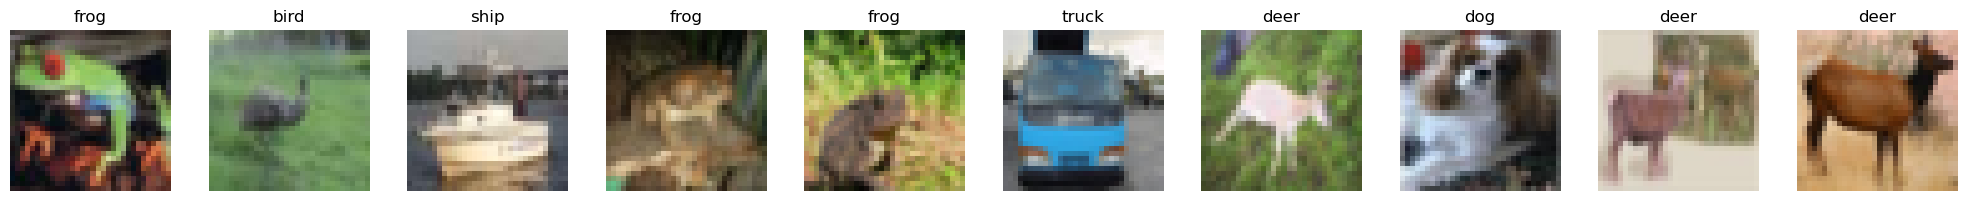

In [46]:
# Save 10 random samples
saved_files = save_cifar10_samples(
    num_samples=10,
    output_dir='cifar10_samples',
    random_seed=42
)

# Display the saved samples
display_saved_samples(saved_files)